In [1]:
# depth_mapping.ipynb

# Python notebook for prototyping implementation of 3D depth mapping algorithm from the following paper:
# J. Wlodek, K. J. Gofron, Y. Q. Cai; Achieving 3D imaging through focus stacking.
# AIP Conf. Proc. 15 January 2019; 2054 (1): 050001. https://doi.org/10.1063/1.5084619

# Bennett Wu - 11/17/2023

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2

In [2]:
def normalize_array(arr: np.array, uint8_mode=False) -> np.array:
    '''
    Normalizes numpy array to be float32 with range 0-1 or uint8 with range 0-255

    arr - array to normalize
    uint8_mode - select float32 or uint8, defaults to float32

    returns - uint8 or float32 numpy array in same shape as input
    '''
    arr = arr.astype('float32')
    arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    if uint8_mode:
        arr *= 255
        arr = arr.astype('uint8')
    return arr


def load_image(path: os.PathLike) -> np.array:
    '''
    Loads a given image in RGB from given path

    path - path to image

    returns - float32 numpy array representing an RGB image
    '''
    try:
        bgr_img = cv2.imread(path)
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        return normalize_array(rgb_img)
    except:
        raise Exception(f'Failed to load image: {path}')


def rgb_to_gray(im: np.array) -> np.array:
    '''
    Converts a RGB image to grayscale

    im - image to convert

    returns - numpy array representing a grayscale image
    '''
    assert len(im.shape) == 3  # Image must be RGB
    return cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)


def plt_img(ax: plt.axis, img: np.array, title='') -> None:
    '''
    Plots given image onto matplot axis with an optional title

    ax - matplot plot axis (can just pass in matplot.pyplot, or a subplot axis)
    img - grayscale or RGB image to plot
    title - optional plot title
    '''
    cmap = 'gray'
    if (len(img.shape) == 3 and img.shape[2] == 3):
        cmap = None
    ax.imshow(img, cmap=cmap)
    ax.axis('off')
    if title:
        ax.set_title(title)


def save_img(path: os.PathLike, img: np.array) -> None:
    '''
    Saves given image to given path. Converts non uint8 images to uint8

    path - path to save image to
    img - image to save
    '''
    if (len(img.shape) == 3):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if (img.dtype != 'uint8'):
        img = normalize_array(img, uint8_mode=True)

    # Ensure output directory exists
    path = os.path.abspath(path)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, img)
    print(f"Image saved at {path}")

In [3]:
# Load images to stack and input focal depths
img_dir = './test_images/'
img_names = [
    'hf001.jpg', 'hf005.jpg', 'hf010.jpg', 'hf015.jpg',
    'hf020.jpg', 'hf025.jpg', 'hf030.jpg', 'hf035.jpg',
]

focal_depths = np.array([
    1, 5, 10, 15, 20, 25, 30, 35
])

images = np.array([
    load_image(os.path.join(img_dir, name)) for name in img_names
])

In [4]:
# Select an image for testing
test_img = images[3]

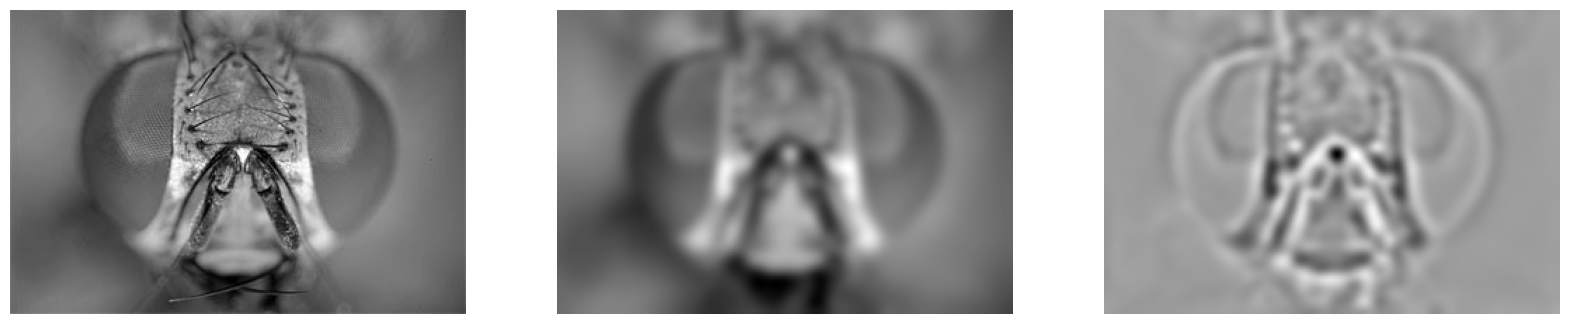

In [5]:
def gauss_convolve(im: np.array, ksize: int) -> np.array:
    '''
    Convolves given image using a gaussian kernel

    im - image to blur
    ksize - Size in pixels of gaussian kernel. Must be odd.

    returns - numpy array of convolved image
    '''
    # ksize must be odd
    assert ksize % 2 == 1
    # Grayscale or RGB images allowed
    assert len(img.shape) == 2 or len(img.shape) == 3

    return cv2.GaussianBlur(im, (ksize, ksize), 0)


def laplacian_convolve(im: np.array, ksize: int) -> np.array:
    '''
    Convolves given image using a laplacian kernel

    im - image to convolve
    ksize - Size in pixels of laplacian kernel. Must be odd.

    returns - numpy array of convolved image
    '''
    # ksize must be odd
    assert ksize % 2 == 1
    # Grayscale or RGB images allowed
    assert len(img.shape) == 2 or len(img.shape) == 3
    return cv2.Laplacian(im, ddepth=cv2.CV_32F, ksize=ksize)


# Test functions with image
img = rgb_to_gray(test_img)
blur = gauss_convolve(img, 25)
sharp = laplacian_convolve(blur, 25)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
plt_img(ax[0], img)
plt_img(ax[1], blur)
plt_img(ax[2], sharp)

In [6]:
# # Function adapted from https://github.com/bznick98/Focus_Stacking @ d61993a

# # Note - This is not working well, a different approach may be needed

# def align_images(images: list[np.array], max_features=1000, good_match_thresh=0.75):
#     # use uint8 images for cv2.drawMatches()
#     images = [normalize_array(img, uint8_mode=True) for img in images]

#     ref = images[0]
#     aligned_images = [ref]

#     # find homography between other images and ref img
#     match_images = []
#     for img in images[1:]:
#         height, width = img.shape

#         detector = cv2.KAZE_create(max_features)

#         # find keypoints and descriptors
#         kp_a, des_a = detector.detectAndCompute(img, None)
#         kp_b, des_b = detector.detectAndCompute(ref, None)

#         # Matcher
#         bf = cv2.BFMatcher()
#         matches = bf.knnMatch(des_a, des_b, k=2)

#         # Apply ratio test
#         good = []
#         for m, n in matches:
#             if m.distance < good_match_thresh*n.distance:
#                 good.append(m)
#         numMatches = int(len(good))
#         matches = good

#         match_images.append(
#             cv2.drawMatches(ref, kp_a, img, kp_b, matches, None)
#         )

#         # extract location of good matches
#         pts_a = np.zeros((numMatches, 2), dtype=np.float32)
#         pts_b = np.zeros((numMatches, 2), dtype=np.float32)

#         for idx, match in enumerate(matches):
#             pts_a[idx, :] = kp_a[match.queryIdx].pt
#             pts_b[idx, :] = kp_b[match.trainIdx].pt

#         H, _ = cv2.findHomography(pts_a, pts_b, cv2.RANSAC)

#         img_warped = cv2.warpPerspective(img, H, (width, height))
#         aligned_images.append(img_warped)

#     return aligned_images, match_images

# grayscale_img = [rgb_to_gray(img) for img in images]
# aligned_images, match_images = align_images(grayscale_img)

# plt_img(plt, match_images[0])

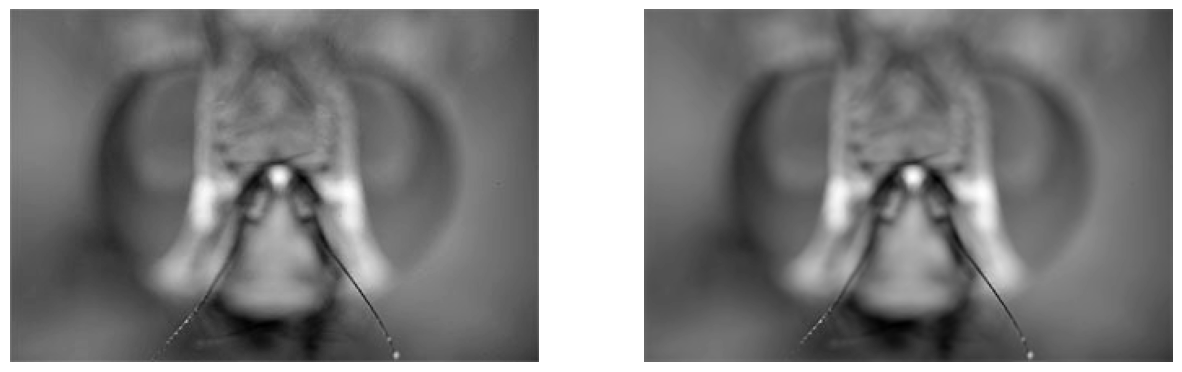

In [7]:
def denoise_image(img: np.array, template_win_size=7, search_win_size=21, filter_strength=10) -> np.array:
    '''
    Denoises a given image

    img - image to denoise
    template_win_size - Size in pixels of the template patch that is used to compute weights. Should be odd. Recommended value 7 pixels 
    search_win_size - Size in pixels of the window that is used to compute weighted average for given pixel. Should be odd. 
                      Affect performance linearly: greater searchWindowsSize - greater denoising time. Recommended value 21 pixels 
    filter_strength - Denoising strength. Higher value removes more noise but removes details.

    returns - numpy array representing denoised image
    '''
    # Window sizes must be odd
    assert template_win_size % 2 == 1
    # Window sizes must be odd
    assert search_win_size % 2 == 1
    # Grayscale or RGB images allowed
    assert len(img.shape) == 2 or len(img.shape) == 3

    img = normalize_array(img, uint8_mode=True)
    img = cv2.fastNlMeansDenoising(
        img, None, template_win_size, search_win_size, filter_strength
    )
    return normalize_array(img)


img = images[1]
gray = normalize_array(rgb_to_gray(img), uint8_mode=True)
denoised = denoise_image(gray, 7, 21, 3)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], gray)
plt_img(ax[1], denoised)

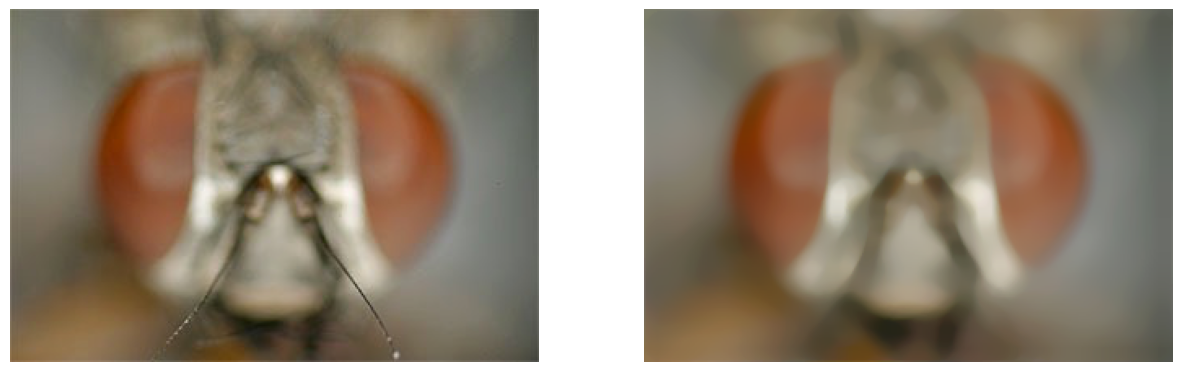

In [8]:
def smooth_image(img: np.array, kernel_size=7) -> np.array:
    '''
    Smoothes given image with a median blur

    img - numpy array of RGB or grayscale image
    kernel_size - Size in pixels of median blur kernel

    returns - numpy array representing smoothed image
    '''
    # Kernel size must be odd
    assert kernel_size % 2 == 1
    # Grayscale or RGB images allowed
    assert len(img.shape) == 2 or len(img.shape) == 3

    img = cv2.medianBlur(img, kernel_size)
    return img


img = images[1]
smoothed = smooth_image(normalize_array(img, uint8_mode=True), 15)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], img)
plt_img(ax[1], smoothed)

In [9]:
class DepthMapArgs:
    # Arguments for alignment of input images
    # max_align_features = 1000
    # good_feature_thresh = 0.85

    # Arguments for denoising input images
    denoise_temp_win_size = 7
    denoise_search_win_size = 21
    denoise_strength = 3

    # Arguments for calculating sharpness values
    gaussian_kernel_size = 3
    laplacian_kernel_size = 3

    # Arguments for smoothing depth map
    merge_tile_size = 3
    smooth_kernel_size = 25

In [10]:
def sharpness_vals(image: np.array, args: DepthMapArgs) -> np.array:
    '''
    Calculates sharpness rankings of given image using Laplacian of Gaussian kernel
    Converts image to grayscale, denoises image, and then runs a LoG kernel over image

    image - numpy array of RGB image to calculate sharpness values of
    args - tuneable arguments for depth mapping algorithm. See DepthMapArgs class

    returns - 2d numpy array of sharpness rankings, higher = sharper
    '''
    assert args.gaussian_kernel_size % 2 == 1  # ksize must be odd
    assert args.laplacian_kernel_size % 2 == 1  # ksize must be odd

    temp_win = args.denoise_temp_win_size
    search_win = args.denoise_search_win_size
    denoise_strength = args.denoise_strength

    gray = rgb_to_gray(image)
    denoise = denoise_image(gray, temp_win, search_win, denoise_strength)
    blur = gauss_convolve(denoise, args.gaussian_kernel_size)
    sharp = laplacian_convolve(blur, args.laplacian_kernel_size)

    return sharp


def depth_mapping(images: np.array, focal_depths: np.array, args: DepthMapArgs) -> tuple[np.array, np.array]:
    '''
    Computes depth map and focus stacked image from given images and focal_depths

    images - array of grayscale or RGB images
    focal_depths - numpy array of focal depths (indexwise match with images)
    args - tuneable arguments for depth mapping algorithm. See DepthMapArgs class

    returns - tuple of depth map (2D uint8 numpy array) and focus stacked image (numpy array simplar to images[0])
    '''
    assert len(images.shape) == 4  # Expect list of RGB images

    # Focal depths should be unique and sorted
    assert np.sum(np.unique(focal_depths) != focal_depths) == 0

    # Align images with on another
    # images, _ = align_images(
    #     images,
    #     args.max_align_features,
    #     args.good_feature_thresh
    # )

    # Normalize depths according to paper: I * (f_max - f_min) / N
    norm = (np.max(focal_depths) - np.min(focal_depths)) / len(focal_depths)
    focal_depths = focal_depths * norm

    # Calculate sharpness ranking of images
    sharpness_ranking = np.array([sharpness_vals(img, args) for img in images])

    # Use image index as proxy for depth for now
    _, height, width = sharpness_ranking.shape
    depth_index = np.zeros((height, width), dtype='uint8')

    tile_size = args.merge_tile_size
    for tile_r in range(0, height - tile_size + 1, tile_size):
        for tile_c in range(0, width - tile_size + 1, tile_size):
            tile_sharp = sharpness_ranking[
                :,
                tile_r: tile_r+tile_size,
                tile_c: tile_c+tile_size
            ]

            # For each tile, find the maximum sharpness in that tile
            # Set depth of entire tile to that maximum sharpness
            max_sharp_index = 0
            max_sharp_val = np.max(tile_sharp[0])
            for i in range(1, tile_sharp.shape[0]):
                if np.max(tile_sharp[i]) > max_sharp_val:
                    max_sharp_index = i
                    max_sharp_val = np.max(tile_sharp[i])

            for r in range(tile_r, tile_r + tile_size):
                for c in range(tile_c, tile_c + tile_size):
                    depth_index[r, c] = max_sharp_index

    # Smooth out depths with a median blur
    depth_index = smooth_image(depth_index, args.smooth_kernel_size)

    # Calculate masks and generate stacked image
    stacked = np.zeros_like(images[0])
    for i in range(len(focal_depths)):
        mask = depth_index == i
        stacked += np.repeat(mask[..., None],
                             images.shape[3], axis=2) * images[i]

    # Scale so that 0 is the furthest point, 255 is the closest
    depth_map = focal_depths[depth_index]
    depth_map = 255 - normalize_array(depth_map, uint8_mode=True)

    return depth_map, stacked

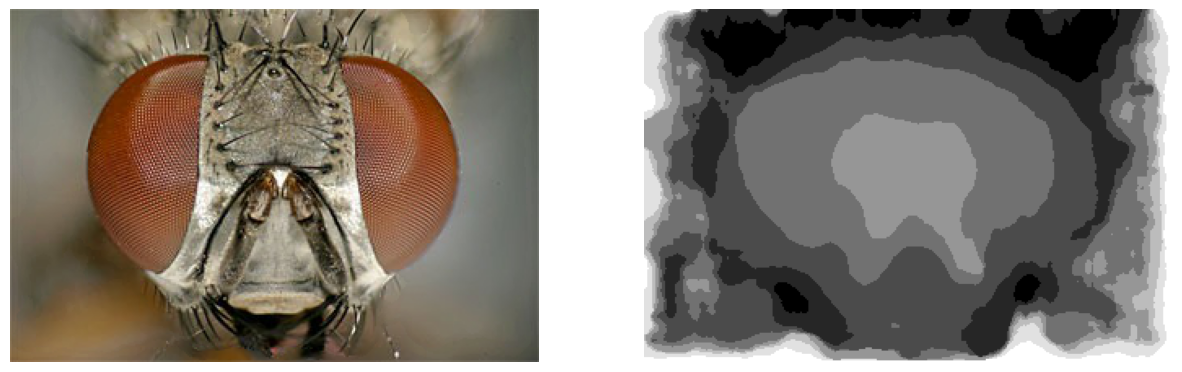

In [11]:
args = DepthMapArgs()

depth, stack = depth_mapping(images, focal_depths, args)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], stack)
plt_img(ax[1], depth)

Image saved at c:\Users\Bennett\Documents\Documents\1. School\2. Fall 2023\CS 445\Final Project\focus-stacking\depth_mapping\outputs\stack.png
Image saved at c:\Users\Bennett\Documents\Documents\1. School\2. Fall 2023\CS 445\Final Project\focus-stacking\depth_mapping\outputs\depth.png


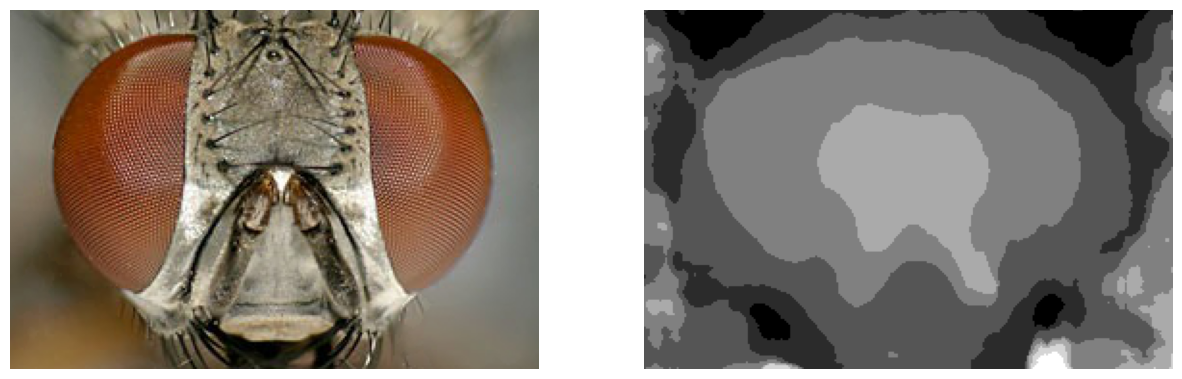

In [12]:
def crop_in(img: np.array, amount: tuple[int, int]) -> np.array:
  '''
  Crops a given image in horizontal or vertical direction

  img - numpy array of image to crop
  amount - tuple of vertical crop and horizontal crop amount

  returns - numpy array represtning cropped image
  '''
  return img[amount[0]:-amount[0], amount[1]:-amount[1]]

crop = (15, 25)
stack_crop = crop_in(stack, crop)
depth_crop = crop_in(depth, crop)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], stack_crop)
plt_img(ax[1], depth_crop)

save_img('./outputs/stack.png', stack_crop)
save_img('./outputs/depth.png', depth_crop)

# Visualize on https://depthplayer.ugocapeto.com/